# testing of sample code

In [1]:
import torch
from PIL import Image
import open_clip
import numpy as np

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
image_path = "cow.jpg"
image = preprocess(Image.open(image_path)).unsqueeze(0)
text = tokenizer(["a diagram", "a dog", "a cat"])

with torch.no_grad(), torch.cuda.amp.autocast():
    print(image.size())
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)[0]

print("Label probs:", text_probs)  # prints: [[1., 0., 0.]]

/home/jeremy/Documents/code/monorepo/openC_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 3, 224, 224])
Label probs: tensor([0.5408, 0.4575, 0.0017])


/home/jeremy/Documents/code/monorepo/openC_env/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/jeremy/Documents/code/monorepo/openC_env/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


# zero shot object detection using sliding windows

In [7]:
import torch

def load_img(image_path):
    img = preprocess(Image.open(image_path)).unsqueeze(0)

    return img

def calc_probs(img, text, model):
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(img)
        text_features = model.encode_text(text)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)[0]
    
    return text_probs

def zero_shot_maps(image_path, prompts, window_size, stride):
    # load the raw image
    img = Image.open(image_path)

    print(img.size)
    # calculate the number of windows
    height = img.size[0]
    width = img.size[1]
    num_windows_height = (height - window_size[0]) // stride + 1
    num_windows_width = (width - window_size[1]) // stride + 1

    # init average score map to 0 and count map for each prompt
    num_prompts = len(prompts)
    # avg_score_maps = np.array([np.zeros((num_windows_height, num_windows_width)) for _ in range(num_prompts)])
    # count_map = np.zeros((num_windows_height, num_windows_width))
    sum_score_maps =  np.array([np.zeros((height, width)) for _ in range(num_prompts)])
    avg_score_maps = np.array([np.zeros((height, width)) for _ in range(num_prompts)])
    count_map = np.array([np.zeros((height, width)) for _ in range(num_prompts)])
    
                         
    print(avg_score_maps.shape)
    print(count_map.shape)


    # init model
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
    tokenizer = open_clip.get_tokenizer('ViT-B-32')

    # tokenize prompts
    text = tokenizer(prompts)

    # sliding window loop
    for i in range(0, num_windows_height):
        for j in range(0, num_windows_width):
            window = img.crop((i * stride,j*stride, 
                              i*stride+window_size[0],j*stride+window_size[1]))
            p_window = preprocess(window).unsqueeze(0)
            print(p_window.size())
            # calc scores for each prompt
            scores = calc_probs(p_window, text, model)
            print(scores)
            # updates summed score maps
            for k in range(num_prompts):
                sum_score_maps[k][
                                    i*stride: i*stride+window_size[0],
                                    j*stride: j*stride+window_size[1]
                                  ] += float(scores[k])
                count_map[k][
                                    i*stride: i*stride+window_size[0],
                                    j*stride: j*stride+window_size[1]
                                  ] += 1


    # avoid zerio division in the avg computation
    for k in range(num_prompts):
        tmp = np.copy(count_map[k])
        tmp[tmp == 0] = 1.0
        count_map[k] = tmp

        avg_score_maps[k] = np.divide(sum_score_maps[k], count_map[k])

    return avg_score_maps, sum_score_maps


image_path = "cow.jpg"
image = preprocess(Image.open(image_path)).unsqueeze(0)
prompts = ["grass field", "cow", "sky", "clouds", "trees"]
window_size = (64,64)
stride = 16

avg_score_maps, sum_score_maps = zero_shot_maps(image_path, prompts, window_size, stride)

(540, 360)
(5, 540, 360)
(5, 540, 360)
torch.Size([1, 3, 224, 224])
tensor([4.0536e-07, 1.1003e-05, 3.4189e-01, 6.5807e-01, 2.4641e-05])
torch.Size([1, 3, 224, 224])
tensor([4.8027e-05, 4.2267e-05, 5.7688e-01, 3.1633e-01, 1.0670e-01])
torch.Size([1, 3, 224, 224])


/home/jeremy/Documents/code/monorepo/openC_env/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


tensor([3.8514e-05, 5.1882e-05, 7.1544e-01, 4.2425e-02, 2.4204e-01])
torch.Size([1, 3, 224, 224])
tensor([3.4381e-05, 6.6555e-05, 4.1493e-01, 2.7825e-03, 5.8219e-01])
torch.Size([1, 3, 224, 224])
tensor([8.9336e-06, 3.5541e-05, 2.8077e-01, 4.1180e-04, 7.1878e-01])
torch.Size([1, 3, 224, 224])
tensor([3.9042e-05, 4.0717e-05, 3.9204e-01, 1.2231e-04, 6.0775e-01])
torch.Size([1, 3, 224, 224])
tensor([4.1122e-04, 5.0190e-05, 9.5997e-02, 1.8586e-05, 9.0352e-01])
torch.Size([1, 3, 224, 224])
tensor([4.7270e-04, 7.4778e-07, 2.4744e-02, 2.6304e-07, 9.7478e-01])
torch.Size([1, 3, 224, 224])
tensor([2.2696e-01, 9.3862e-05, 2.5039e-02, 7.1183e-07, 7.4791e-01])
torch.Size([1, 3, 224, 224])
tensor([9.6193e-01, 3.7008e-04, 1.3706e-03, 1.0176e-07, 3.6325e-02])
torch.Size([1, 3, 224, 224])
tensor([9.9816e-01, 8.9080e-05, 1.8697e-04, 3.3218e-08, 1.5674e-03])
torch.Size([1, 3, 224, 224])
tensor([9.9985e-01, 1.7884e-05, 9.7157e-05, 3.4788e-08, 3.9469e-05])
torch.Size([1, 3, 224, 224])
tensor([9.9991e-01, 

Text(0.5, 0.98, 'Zero shot object detection using sliding window of: cow.jpg')

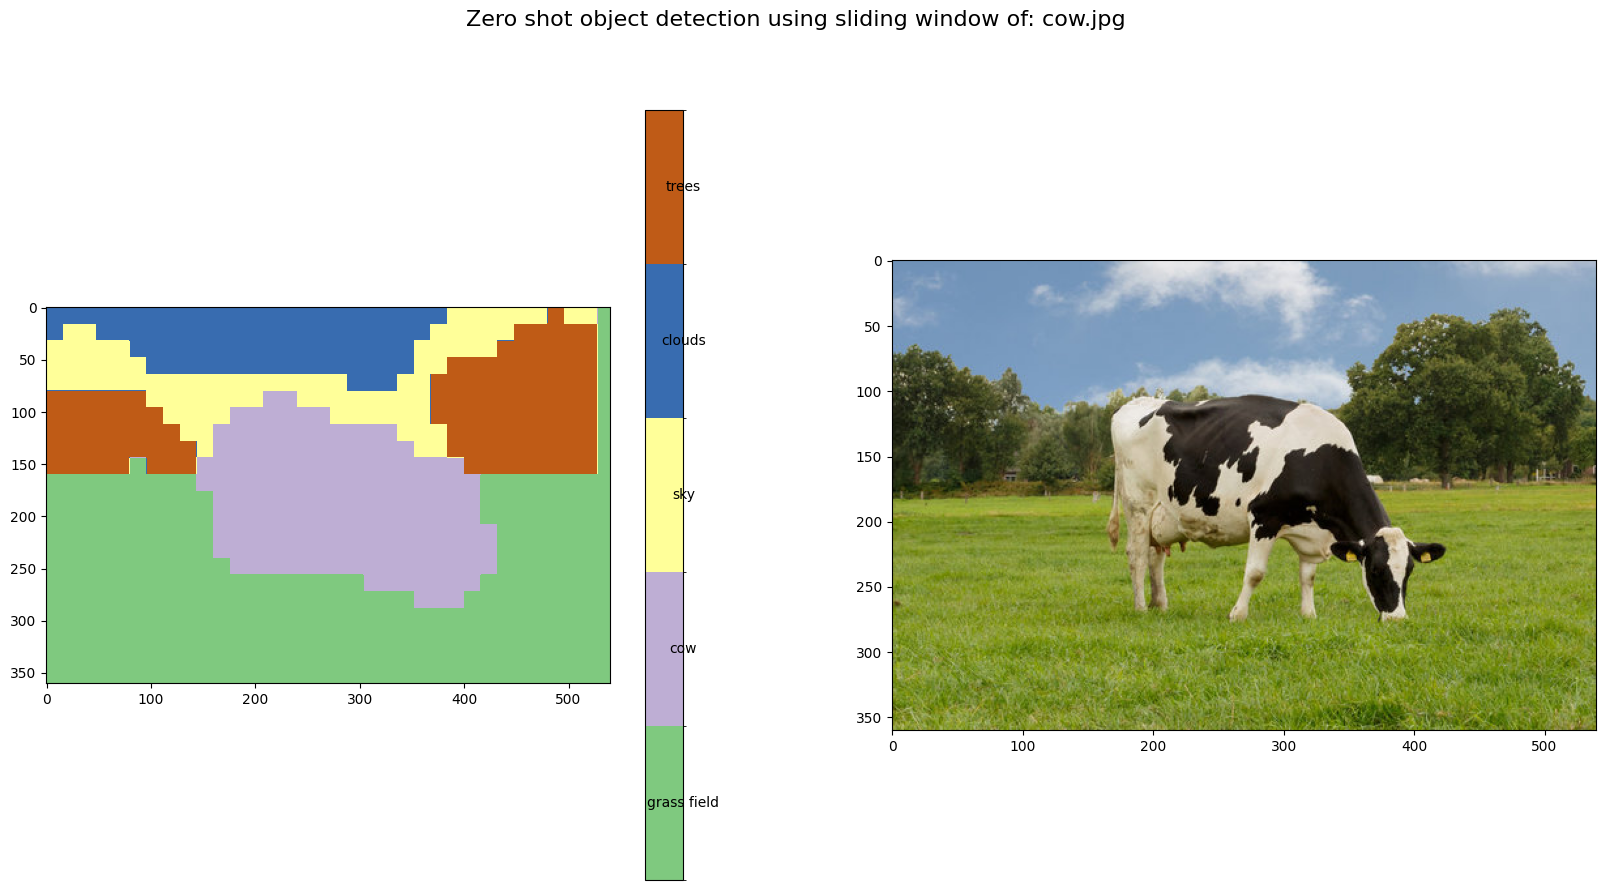

In [31]:
import matplotlib.pyplot as plt
import matplotlib

img = Image.open(image_path)

class_label_map = np.zeros((img.size[0], img.size[1]))

for x in range(img.size[0]):
    for y in range(img.size[1]):
        class_label_map[x,y] = avg_score_maps[:, x, y].argmax(axis=0)


bounds = np.linspace( -0.5, len(prompts)-0.5, len(prompts)+1)
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=len(prompts)+2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

im = ax[0].imshow(class_label_map[::].transpose(1,0), cmap='Accent', norm=norm)


cbar = ax[0].figure.colorbar(im)
cbar.ax.get_yaxis().set_ticks([])

for j, lab in enumerate(prompts):
    cbar.ax.text(1.0, j, lab, ha='center', va='center')


ax[1].imshow(img)


# Add a title to the entire figure
plt.suptitle(f'Zero shot object detection using sliding window of: {image_path}', fontsize=16)